In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00


In [2]:
#importing all the required libraries
import torch
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import Parallel, delayed

In [3]:
#connecting to google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#reading the training data into a dataframe
train_df=pd.read_csv("drive/MyDrive/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.shape

(159571, 8)

In [6]:
train_df=train_df[:15000]

In [7]:
X=train_df['comment_text']
y=train_df.drop(columns=['comment_text','id'])

In [8]:
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
14995,0,0,0,0,0,0
14996,0,0,0,0,0,0
14997,0,0,0,0,0,0
14998,0,0,0,0,0,0


In [9]:
X_train, X_val, y_train, y_val=train_test_split(X,y,test_size=0.2, random_state=42)

We need to use BERT transformer to generate word embeddings:

In [10]:
#loading bert model and tokenizer
model_name="bert-base-uncased"
tokenizer=transformers.BertTokenizer.from_pretrained(model_name)
bert_model=transformers.BertModel.from_pretrained(model_name)

In [11]:
def conv_to_tensor(text,max_len):
  tokenized_arr=tokenizer.encode(text,add_special_tokens=True)[:max_len]
  padded_arr=np.array(tokenized_arr+[0]*(max_len-len(tokenized_arr)))
  return padded_arr

In [12]:
conv_to_tensor(X_train.iloc[0],100)

array([  101,  3021,  1010,  1045,  9530, 10841,  2099,  1010,  1998,
        2001,  6195,  4851,  2008,  2870,  1012,  2057,  2079,  2031,
       10195,  2013,  2660,  2040,  6976,  1996,  1042,  1011, 11118,
        3931,  1010,  2061,  2057,  2763, 11276,  2000,  2695,  2023,
        2045,  2065,  2017,  2123,  1005,  1056,  2031,  2204,  4216,
        2006,  2023,  2525,  1012,  1011,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
embeddings=[]
embeddings.append(Parallel(n_jobs=-1)(delayed(conv_to_tensor)(text,100) for text in X_train))

In [15]:
embeddings=torch.squeeze(torch.tensor(embeddings,dtype=torch.float32)).long().to(device)

<ipython-input-15-2ad7c178fa29>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings=torch.squeeze(torch.tensor(embeddings,dtype=torch.float32)).long().to(device)


In [16]:
embeddings.shape

torch.Size([12000, 100])

In [17]:
print(embeddings)

tensor([[  101,  3021,  1010,  ...,     0,     0,     0],
        [  101,  2417,  7442,  ...,     0,     0,     0],
        [  101,  1000,  2400,  ...,     0,     0,     0],
        ...,
        [  101,  1000,  1045,  ...,     0,     0,     0],
        [  101,  1000,  6090,  ...,  4090,  2575, 11320],
        [  101,  1007,  1996,  ...,     0,     0,     0]], device='cuda:0')


In [18]:
val_embeddings=[]
val_embeddings.append(Parallel(n_jobs=-1)(delayed(conv_to_tensor)(text,100) for text in X_val))

In [19]:
val_embeddings=torch.squeeze(torch.tensor(val_embeddings,dtype=torch.float32)).long().to(device)

In [20]:
train_data_loader=DataLoader(embeddings,batch_size=128,shuffle=True)
val_data_loader=DataLoader(val_embeddings,batch_size=128,shuffle=False)

In [21]:
bert_model.to(device)

with torch.no_grad():
    train_data = iter(train_data_loader)
    val_data = iter(val_data_loader)

    x_train = torch.empty(0).to(device)
    x_val = torch.empty(0).to(device)

    for i in range(len(train_data_loader)):
        batch = next(train_data)
        outputs = bert_model(batch.to(device))
        x_train = torch.cat((x_train, outputs[0]), dim=0)
        print(f"Iteration: {i} for train")

    for i in range(len(val_data_loader)):
        batch1 = next(val_data)
        outputs1 = bert_model(batch1.to(device))
        x_val = torch.cat((x_val, outputs1[0]), dim=0)
        print(f"Iteration: {i} for val")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Iteration: 0 for train
Iteration: 1 for train
Iteration: 2 for train
Iteration: 3 for train
Iteration: 4 for train
Iteration: 5 for train
Iteration: 6 for train
Iteration: 7 for train
Iteration: 8 for train
Iteration: 9 for train
Iteration: 10 for train
Iteration: 11 for train
Iteration: 12 for train
Iteration: 13 for train
Iteration: 14 for train
Iteration: 15 for train
Iteration: 16 for train
Iteration: 17 for train
Iteration: 18 for train
Iteration: 19 for train
Iteration: 20 for train
Iteration: 21 for train
Iteration: 22 for train
Iteration: 23 for train
Iteration: 24 for train
Iteration: 25 for train
Iteration: 26 for train
Iteration: 27 for train
Iteration: 28 for train
Iteration: 29 for train
Iteration: 30 for train
Iteration: 31 for train
Iteration: 32 for train
Iteration: 33 for train
Iteration: 34 for train
Iteration: 35 for train
Iteration: 36 for train
Iteration: 37 for train
Iteration: 38 for train
Iteration: 39 for train
Iteration: 40 for train
Iteration: 41 for train
It

In [22]:
torch.cuda.empty_cache()

In [23]:
x_train.shape

torch.Size([12000, 100, 768])

In [24]:
class CustomDataset(Dataset):
  def __init__(self,embeddings,labels):
    self.embeddings=embeddings
    self.labels=torch.tensor(np.array(labels),dtype=torch.float32).to(device)
  def __len__(self):
    return self.embeddings.shape[0]
  def __getitem__(self,idx):
    return {"embedding":self.embeddings[idx],"label":self.labels[idx]}

In [25]:
train_data=CustomDataset(x_train,y_train)
val_data=CustomDataset(x_val,y_val)

In [26]:
train_data_loader=DataLoader(train_data,batch_size=10,shuffle=True)
val_data_loader=DataLoader(val_data,batch_size=10,shuffle=False)

In [27]:
batch=iter(train_data_loader)
next(batch)['embedding'].shape

torch.Size([10, 100, 768])

In [28]:
class ClassCNN(torch.nn.Module):
  def __init__(self,embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
    super(ClassCNN, self).__init__()
    self.static = static
    self.embed = nn.Embedding(embed_num, embed_dim)
    self.convs1 = nn.ModuleList([nn.Conv2d(1, kernel_num, (K, embed_dim)) for K in kernel_sizes])
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    if self.static:
        x = torch.autograd.Variable(x)

    x = x.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]

    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]

    x = torch.cat(x, 1)
    x = self.dropout(x)
    logit = self.fc1(x)
    output = self.sigmoid(logit)
    return output

In [29]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [30]:
model = ClassCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
).to(device)

In [31]:
#sample:
model(next(batch)['embedding']).shape

torch.Size([10, 6])

In [32]:
criterion = torch.nn.BCELoss()
optimizer = transformers.AdamW(model.parameters(), lr=0.002)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
from tqdm import tqdm

model.to(device)
model.train()

num_epochs = 30
best_validation_loss = float('inf')
save_interval = 5
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(batch['embedding'])
        optimizer.zero_grad()

        loss = criterion(outputs, batch['label'])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_data_loader)
    train_losses.append(average_loss)

    model.eval()
    with torch.no_grad():
      val_loss=0
      for batch in val_data_loader:
        batch={k: v.to(device) for k, v in batch.items()}

        outputs=model(batch['embedding'])
        val_loss=criterion(outputs,batch['label'])
        val_loss+=val_loss.item()

      val_loss /= len(val_data_loader)
      val_losses.append(val_loss.cpu())
      if epoch % save_interval == 0:
          best_validation_loss = val_loss
          best_model_state = model.state_dict()
          print("Saving model....")
          torch.save(best_model_state, f"best_model_epoch_{epoch}.pt")

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {average_loss:.4f} - Validation Loss: {val_loss:.4f}")
print("Training finished.")


Epoch 1/30: 100%|██████████| 1200/1200 [00:10<00:00, 110.20it/s]


Saving model....
Epoch 1/30 - Train Loss: 0.2230 - Validation Loss: 0.0011


Epoch 2/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.44it/s]


Epoch 2/30 - Train Loss: 0.1434 - Validation Loss: 0.0011


Epoch 3/30: 100%|██████████| 1200/1200 [00:07<00:00, 163.25it/s]


Epoch 3/30 - Train Loss: 0.1412 - Validation Loss: 0.0011


Epoch 4/30: 100%|██████████| 1200/1200 [00:07<00:00, 158.09it/s]


Epoch 4/30 - Train Loss: 0.1388 - Validation Loss: 0.0012


Epoch 5/30: 100%|██████████| 1200/1200 [00:07<00:00, 162.46it/s]


Epoch 5/30 - Train Loss: 0.1337 - Validation Loss: 0.0012


Epoch 6/30: 100%|██████████| 1200/1200 [00:07<00:00, 160.58it/s]


Saving model....
Epoch 6/30 - Train Loss: 0.1284 - Validation Loss: 0.0013


Epoch 7/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.91it/s]


Epoch 7/30 - Train Loss: 0.1237 - Validation Loss: 0.0013


Epoch 8/30: 100%|██████████| 1200/1200 [00:07<00:00, 163.12it/s]


Epoch 8/30 - Train Loss: 0.1169 - Validation Loss: 0.0016


Epoch 9/30: 100%|██████████| 1200/1200 [00:07<00:00, 157.85it/s]


Epoch 9/30 - Train Loss: 0.1116 - Validation Loss: 0.0016


Epoch 10/30: 100%|██████████| 1200/1200 [00:07<00:00, 156.91it/s]


Epoch 10/30 - Train Loss: 0.1049 - Validation Loss: 0.0020


Epoch 11/30: 100%|██████████| 1200/1200 [00:07<00:00, 160.12it/s]


Saving model....
Epoch 11/30 - Train Loss: 0.1005 - Validation Loss: 0.0017


Epoch 12/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.46it/s]


Epoch 12/30 - Train Loss: 0.0942 - Validation Loss: 0.0017


Epoch 13/30: 100%|██████████| 1200/1200 [00:07<00:00, 162.40it/s]


Epoch 13/30 - Train Loss: 0.0897 - Validation Loss: 0.0021


Epoch 14/30: 100%|██████████| 1200/1200 [00:07<00:00, 158.30it/s]


Epoch 14/30 - Train Loss: 0.0850 - Validation Loss: 0.0028


Epoch 15/30: 100%|██████████| 1200/1200 [00:07<00:00, 162.01it/s]


Epoch 15/30 - Train Loss: 0.0803 - Validation Loss: 0.0022


Epoch 16/30: 100%|██████████| 1200/1200 [00:07<00:00, 160.10it/s]


Saving model....
Epoch 16/30 - Train Loss: 0.0771 - Validation Loss: 0.0030


Epoch 17/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.42it/s]


Epoch 17/30 - Train Loss: 0.0735 - Validation Loss: 0.0029


Epoch 18/30: 100%|██████████| 1200/1200 [00:07<00:00, 162.74it/s]


Epoch 18/30 - Train Loss: 0.0708 - Validation Loss: 0.0036


Epoch 19/30: 100%|██████████| 1200/1200 [00:10<00:00, 116.04it/s]


Epoch 19/30 - Train Loss: 0.0666 - Validation Loss: 0.0036


Epoch 20/30: 100%|██████████| 1200/1200 [00:10<00:00, 117.54it/s]


Epoch 20/30 - Train Loss: 0.0641 - Validation Loss: 0.0031


Epoch 21/30: 100%|██████████| 1200/1200 [00:08<00:00, 146.94it/s]


Saving model....
Epoch 21/30 - Train Loss: 0.0625 - Validation Loss: 0.0035


Epoch 22/30: 100%|██████████| 1200/1200 [00:08<00:00, 146.46it/s]


Epoch 22/30 - Train Loss: 0.0607 - Validation Loss: 0.0032


Epoch 23/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.78it/s]


Epoch 23/30 - Train Loss: 0.0581 - Validation Loss: 0.0043


Epoch 24/30: 100%|██████████| 1200/1200 [00:07<00:00, 163.37it/s]


Epoch 24/30 - Train Loss: 0.0567 - Validation Loss: 0.0046


Epoch 25/30: 100%|██████████| 1200/1200 [00:07<00:00, 158.67it/s]


Epoch 25/30 - Train Loss: 0.0549 - Validation Loss: 0.0044


Epoch 26/30: 100%|██████████| 1200/1200 [00:07<00:00, 162.75it/s]


Saving model....
Epoch 26/30 - Train Loss: 0.0547 - Validation Loss: 0.0055


Epoch 27/30: 100%|██████████| 1200/1200 [00:07<00:00, 161.43it/s]


Epoch 27/30 - Train Loss: 0.0524 - Validation Loss: 0.0053


Epoch 28/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.95it/s]


Epoch 28/30 - Train Loss: 0.0529 - Validation Loss: 0.0053


Epoch 29/30: 100%|██████████| 1200/1200 [00:07<00:00, 152.52it/s]


Epoch 29/30 - Train Loss: 0.0499 - Validation Loss: 0.0050


Epoch 30/30: 100%|██████████| 1200/1200 [00:07<00:00, 159.47it/s]


Epoch 30/30 - Train Loss: 0.0496 - Validation Loss: 0.0054
Training finished.


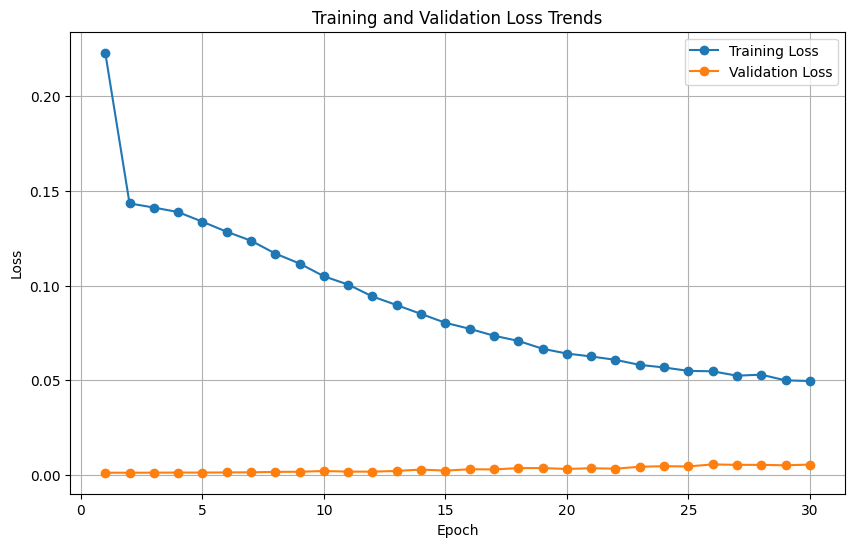

In [34]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Trends")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
y.sum().sum()/y.count().sum()

0.036866666666666666

so, the data is imbalanced, we will calculate the auc score.

In [36]:
model.eval()
with torch.no_grad():
  y_preds=[]
  for batch in val_data_loader:
    batch={k: v.to(device) for k, v in batch.items()}
    pred_labels=model(batch['embedding'])
    y_preds.extend(pred_labels.cpu().numpy().tolist())

In [37]:
y_preds=np.array(y_preds)
y_preds.shape

(3000, 6)

In [38]:
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_val.values,y_preds,average=None)
df_accuracy = pd.DataFrame({"label": y.columns, "auc": auc})
df_accuracy.sort_values('auc')[::-1]

,label,auc
3,threat,0.600067
5,identity_hate,0.556648
4,insult,0.544835
0,toxic,0.542428
1,severe_toxic,0.524104
2,obscene,0.517546


In [62]:
def get_hate_score(sentence,model):
  padded_sent=torch.tensor(conv_to_tensor(sentence,100)).unsqueeze(dim=0).to(device)
  with torch.no_grad():
        embedding = bert_model(padded_sent)
  last_hidden_state = embedding.last_hidden_state
  df_conf=pd.DataFrame({"label": y.columns, "confidence scores": model(last_hidden_state).cpu().detach().numpy()[0]})
  return df_conf

In [63]:
model.load_state_dict(torch.load('best_model_epoch_25.pt',map_location=device))
model.eval()
print(get_hate_score("I hate the current president",model))

           label  confidence scores
0          toxic           0.119608
1   severe_toxic           0.000265
2        obscene           0.009167
3         threat           0.000713
4         insult           0.008279
5  identity_hate           0.001410
